# RL tutorial using OpenAI-Gym

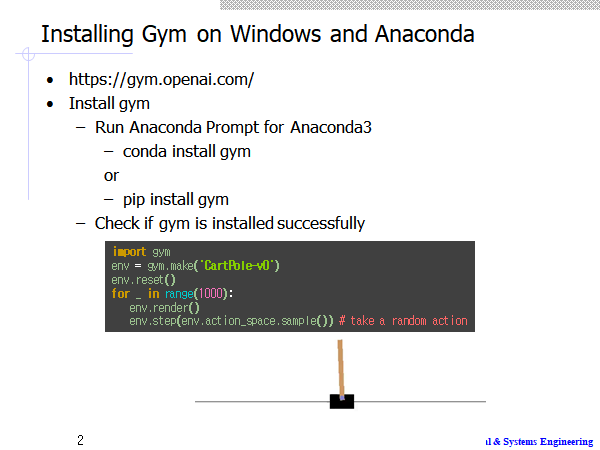

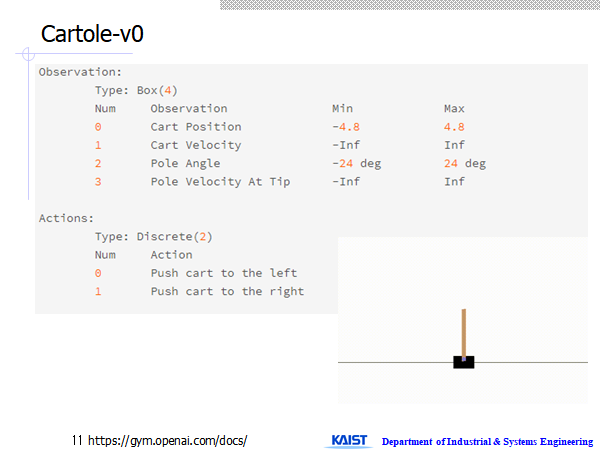

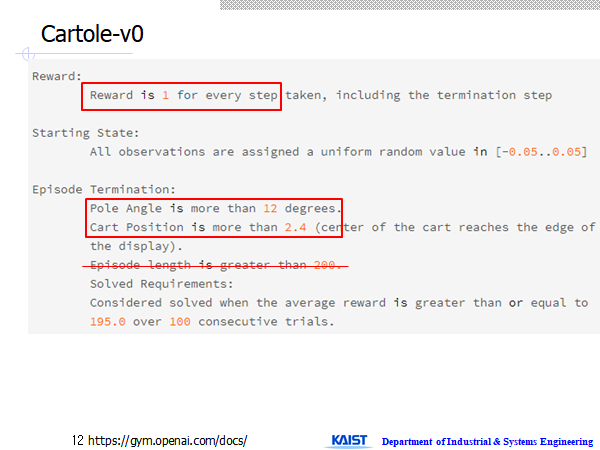

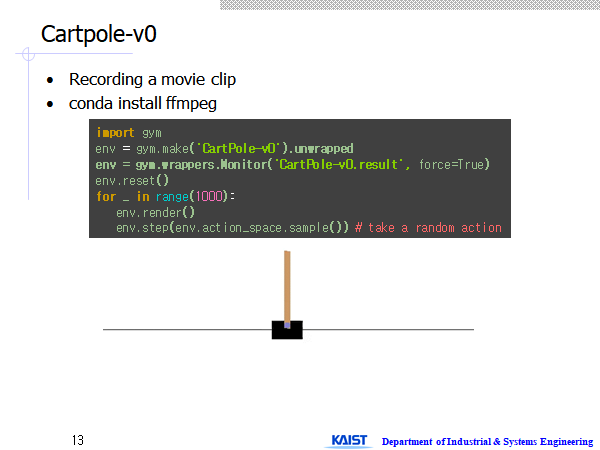

## Simple code first

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Reward definition function

- Default reward : +1 for each step
- We separate a reward function for reward modification later

In [2]:
def reward(obs, r):
#     return np.float32(r + 10*abs(obs[2]))
    return np.float32(r)

## Simple heuristic policy

In [3]:
def simpleHeuristic(env):
    obs = env.reset()
    # obs = [x_pos, x_vel, angle, pole tip speed]
    # episode ends (done = True) when obs[2] > 0.20944 (12 degree)
    i = 1
    done = False
    ret = 0
    while not done:
        env.render()
        action = getAction(obs)
        # action = env.action_space.sample()
        obs, r, done, info = env.step(action)
        r = reward(obs, r) 
        ret += r
    print (f"Score = {ret}")

### Heuristic policy using angle only

In [4]:
def getAction(obs):
    if obs[2] < 0:
        return 0  # left
    else:
        return 1  # right


### Heuristic policy using angle and position

In [5]:
def getAction(obs):
    pos = obs[0]
    ang = obs[2]
    if 10*ang - pos < 0:
        return 0  # left
    else:
        return 1  # right


### Heuristic policy using angle, position, and velocity

In [6]:
def getAction(obs):
    pos = obs[0]
    vel = obs[1]
    ang = obs[2]
    if 10*ang + pos - vel < 0:
        return 0  # left
    else:
        return 1  # right

In [7]:
env = gym.make('CartPole-v0').unwrapped
simpleHeuristic(env)
env.close()

Score = 470.0


In [8]:
env.close()

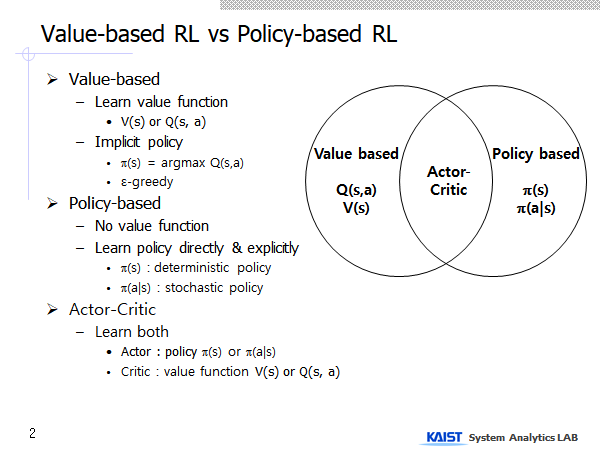

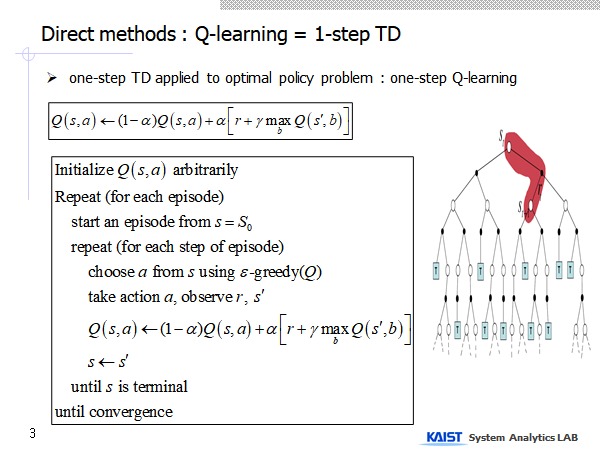

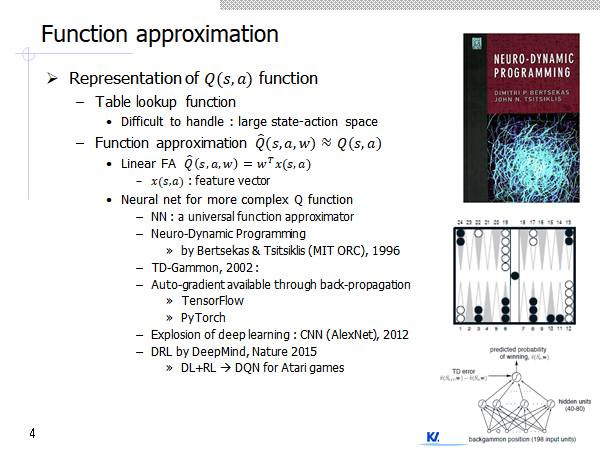

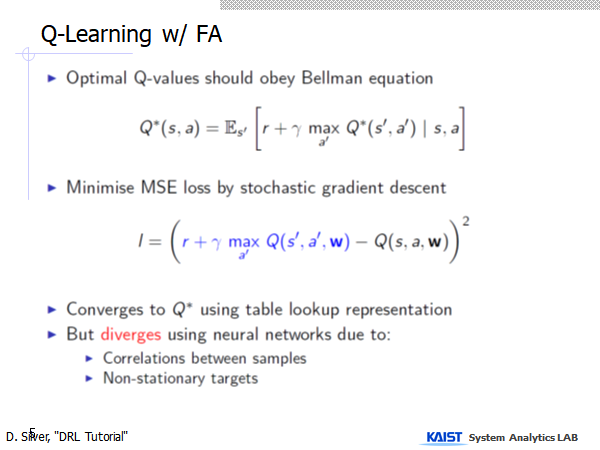

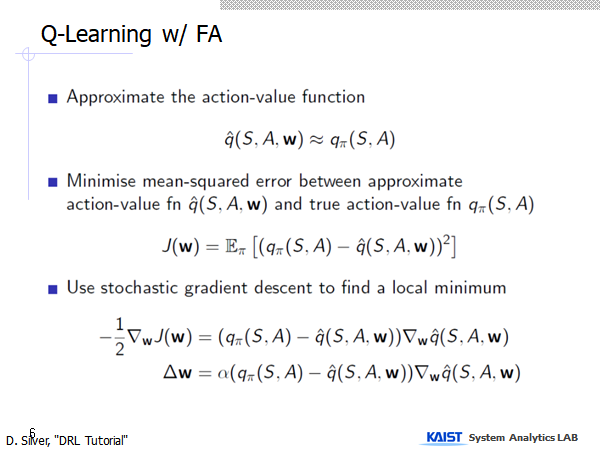

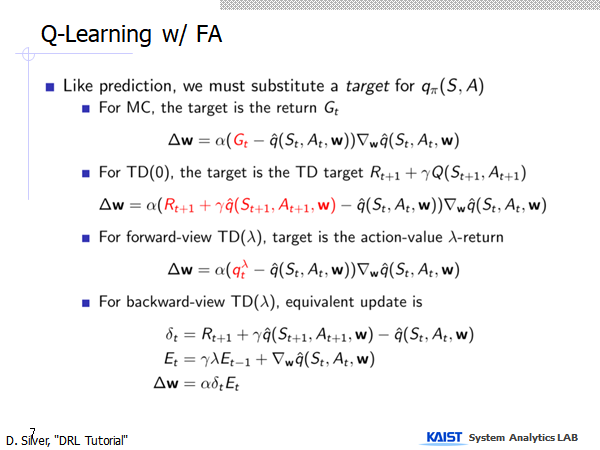

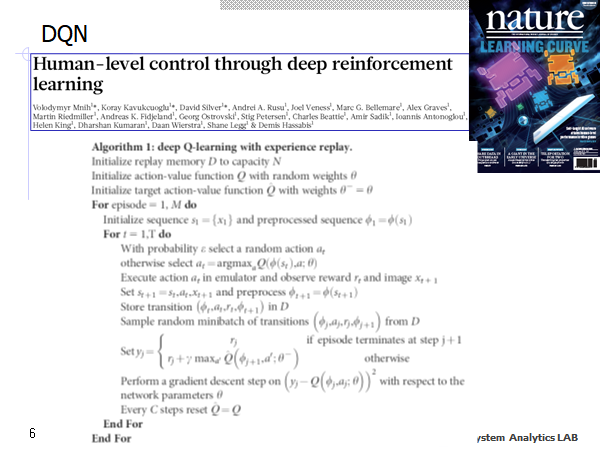

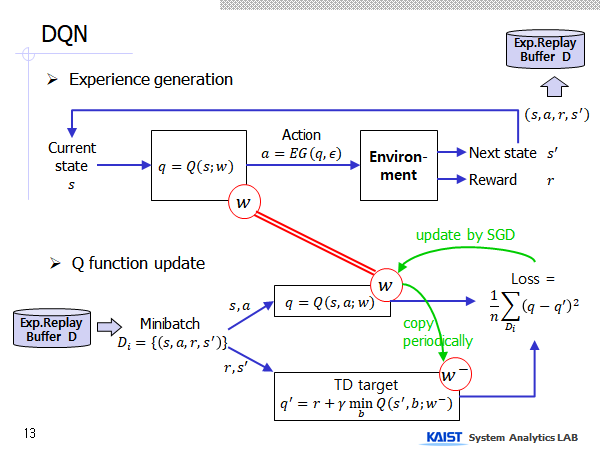

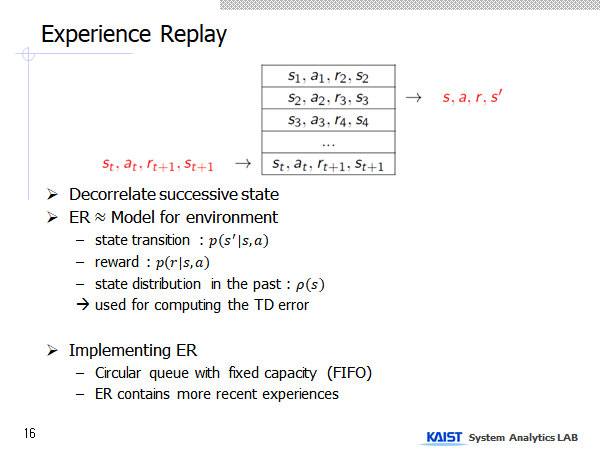

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def segTuple(self, s, a, r, sp, done):
        seg = (s, a, r, sp, done)
        return seg

    def push(self, s, a, r, sp, done):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = self.segTuple(s,a,r,sp,done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def clear(self):
        self.position = 0
        self.memory = []

    def getLast(self):
        p = self.position - 1
        if p < 0:  p = self.capacity - 1
        return self.memory[p]

## Agent class

In [4]:
class AgentBase:
    def __init__(self, env):
        self.env = env
        self.eps = 0.5
        self.dimState = env.observation_space.shape[0]
        self.dimAction = env.action_space.n
        self.gamma = 0.99
        self.rb = ReplayMemory(50000)

    def getStateRep(self, obs):
        return obs

    def getQ(self, s):
        return self.Q[s]

    def piGreedy(self, state):
        q = self.getQ(state)
        a = q.argmax()
        return a

    def getAction(self, state):  # eps-greedy policy
        # eps-greedy
        if np.random.random() < self.eps:
            a = np.random.choice(self.dimAction)
            self.eps *= 0.99
            # print (f"exploration move, eps={self.eps}")
        else:
            a = self.piGreedy(state)
        return a

    @staticmethod
    def getSigmoid(z):
        exp_z = np.exp(z)
        return exp_z / (1+exp_z)

    @staticmethod
    def getSoftmax(z, tau=1):
        exp_z = np.exp((z - np.max(z)) / tau)
        return exp_z / exp_z.sum()

    def piSoftmax(self, state):
        q = self.getQ(state)
        p = self.getSoftmax(q).reshape(-1)
        a = np.random.choice(self.dimAction, p=p)
        return a

    def runEpisode1(self, saveRB=True, maxStep=200, render=False):
        obs = self.env.reset()
        s = self.getStateRep(obs)
        done = False
        ret = 0
        nStep = 0
        while not done:
            if render:
                self.env.render()
            a = self.getAction(s)
            # a = self.piSoftmax(s)
            obs, r, done, info = self.env.step(a)
            r = reward(obs, r)
            ret += r
            sp = self.getStateRep(obs)
            if saveRB:
                self.rb.push(s, a, r, sp, done)
            s = sp
            nStep += 1
            if nStep >= maxStep:  # 500 for v1
                break
        self.nStep = nStep
        if not done and self.gamma < 1:
            ret += r / (1-self.gamma)
        return ret
    
    
    def runTest(self, nEpisode=1, maxStep=1000):
        eps = self.eps
        self.eps = 0
        i = 0
        while i < nEpisode:
            i += 1
            ret = self.runEpisode1(saveRB=False, maxStep=maxStep, render=True)
            print(f"Test episode {i}, return = {ret} in {self.nStep} steps")
        self.eps = eps

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, lsize):
        super().__init__()
        self.layers = nn.ModuleList()
        self.n_layers = len(lsize) - 1
        for i in range(self.n_layers):
            self.layers.append(torch.nn.Linear(lsize[i], lsize[i+1]))
            # self.layers.append(nn.BatchNorm2d(lsize[i]))

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        for i in range(self.n_layers):
            x = self.layers[i](x)
            if i < self.n_layers-1:
                # x = torch.tanh(x)
                x = F.relu(x)
        return x  # softmax is done within F.cross_entropy
        # return F.softmax(x, dim=-1)

    def save(self, fn):
        torch.save(self.state_dict(), fn)

    def load(self, fn):
        self.load_state_dict(torch.load(fn))


In [6]:
class AgentNN(AgentBase):
    def __init__(self, env):
        super().__init__(env)
        self.prepareNN()

    def prepareNN(self):
        self.device = torch.device('cpu')

        # self.qf = LinFA(self.dimState, self.dimAction)
        # self.qfTarget = LinFA(self.dimState, self.dimAction)

        H = 256
        lsize = [self.dimState, H, self.dimAction]
        self.qf = MLP(lsize).to(self.device)
        self.qfTarget = MLP(lsize).to(self.device)
        self.qfTarget.eval()

        # self.optimizer = optim.Adam(self.qf.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.qf.parameters(), lr=0.01) #, weight_decay=0.000001)
#         self.optimizer = optim.SGD(self.qf.parameters(), lr=0.01, weight_decay=0.000001)
        self.lrScheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.97)


    def load(self, fn):
        self.qf.load_state_dict(torch.load(fn))
        self.updateTarget()
    def save(self, fn):
        torch.save(self.qf.state_dict(), fn)

    def updateTarget(self):
        self.qfTarget.load_state_dict(self.qf.state_dict())

    def getStateRep(self, s):
        sTensor = torch.tensor(s, dtype=torch.float32).view(1,len(s))
        return sTensor

    def getQ(self, stateTensor):
        s = stateTensor.to(self.device)
        with torch.no_grad():
            q = self.qf(s)
        q = q.cpu().numpy()
        return q

    # list(zip([1, 2, 3], [4, 5, 6]))
    # [(1, 4), (2, 5), (3, 6)]
    # >>> list(zip([1, 2, 3], [4, 5, 6], [7, 8, 9]))
    # [(1, 4, 7), (2, 5, 8), (3, 6, 9)]
    # >> > list(zip("abc", "def"))
    # [('a', 'd'), ('b', 'e'), ('c', 'f')]
    def trainBatch(self, batch):
        # batch.shape = (N,4), len(batch) = N
        # batch[0] : 첫 data
        L = len(batch)   # *batch : batch내의 data를 unpack
        L1 = [L,1]
        data = list(zip(*batch))  # batch를 transpose해서, data[i] : batch의 i-th column
        S = torch.cat(data[0]).view([L, self.dimState]).to(self.device)
        A = torch.tensor(data[1]).view(L1).to(self.device)
        R = torch.tensor(data[2]).view(L1).to(self.device)
        SP = torch.cat(data[3]).view([L, self.dimState]).to(self.device)
        done = torch.tensor(data[4]).view(L1).to(self.device)
        notDone = ~done

        with torch.no_grad():
#             qp = self.qf(SP)
            qp = self.qfTarget(SP)
            qp = qp * notDone  # mask qp to zero for final states
            (maxqp,idx) = qp.max(dim=-1)
            T = R + self.gamma * maxqp.view(L1)
#         qp = self.qf(SP)
#         qp = qp * notDone  # mask qp to zero for final states
#         (maxqp,idx) = qp.max(dim=-1)
#         T = R + self.gamma * maxqp.view(L1)

        Q = self.qf(S).gather(1,A).view(L1)
        loss = F.mse_loss(Q, T)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # for param in self.qf.parameters():
        #     param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        return loss.item()


    def trainFromRB(self):
        loss = 0.0
        n = 0
        BATCH_SIZE = 128
        if len(self.rb) < BATCH_SIZE:
            return loss
        N = 10 * len(self.rb) // BATCH_SIZE
        N = min(N, 128)
        for i in range(N):
            batch = self.rb.sample(BATCH_SIZE)
            loss += self.trainBatch(batch)
            n += 1
        return loss/n

    def runMany(self, nEpisode=1000, maxStep=200):
        retHist = []

        # self.load("Cartpole-100")
        # self.eps = 0
        i = 0
        max5 = 0
        while i < nEpisode:
            i += 1
            ret = self.runEpisode1(maxStep=maxStep)
            retHist.append(ret)
            if i % 1 == 0:
                loss = self.trainFromRB()
                print (i, f"loss = {loss}, return = {ret}")
            if i % 10 == 0:
                self.updateTarget()
                self.lrScheduler.step()
                print (f"param copied.  LR = {self.optimizer.param_groups[0]['lr']}, eps={self.eps}")
            if i > 5:
                avg5 = sum(retHist[-5:])/5
                if avg5 > max5 and max(retHist[-5:])==retHist[-1]:
                    max5 = avg5
                    print (f"iter {i}, avg5 = {avg5} updated")
                    if avg5 > 100:
                        self.save(f"saved/Cartpole-v0.best-{avg5:.0f}")
                    # self.updateTarget()
                    print(f"param copied.  LR = {self.optimizer.param_groups[0]['lr']}, eps={self.eps}")
                    if avg5 == maxStep:
                        print (f"averge reached {maxStep} after {i} episodes. Solution found")
                        break

        plt.plot(retHist)
        plt.show()

### Train AgentNN

In [ ]:
env = gym.make('CartPole-v0').unwrapped
# env = gym.make('CartPole-v1').unwrapped
agent = AgentNN(env)
agent.runMany(1000, maxStep=2000)

1 loss = 0.0, return = 9.0
2 loss = 0.0, return = 10.0
3 loss = 0.0, return = 9.0
4 loss = 0.0, return = 12.0
5 loss = 0.0, return = 19.0
6 loss = 0.0, return = 12.0
7 loss = 0.0, return = 10.0
8 loss = 0.0, return = 10.0
9 loss = 0.0, return = 11.0
10 loss = 0.0, return = 14.0
param copied.  LR = 0.01, eps=0.32130580104235906
iter 10, avg5 = 11.4 updated
param copied.  LR = 0.01, eps=0.32130580104235906
11 loss = 0.27463765665888784, return = 17.0
iter 11, avg5 = 12.4 updated
param copied.  LR = 0.01, eps=0.2964832232007497


C:\ProgramData\Miniconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


12 loss = 0.08437475833025845, return = 13.0
13 loss = 0.02235532315292706, return = 15.0
14 loss = 0.010814914873872813, return = 12.0
15 loss = 0.007067028998530337, return = 9.0
16 loss = 0.008902391946564118, return = 10.0
17 loss = 0.008989522761354844, return = 10.0
18 loss = 0.008465699720545672, return = 12.0
19 loss = 0.008213626412565218, return = 12.0
20 loss = 0.00873175397929218, return = 12.0
param copied.  LR = 0.01, eps=0.2260218251332377
21 loss = 0.26506190864663376, return = 11.0
22 loss = 0.0752635920420289, return = 12.0
23 loss = 0.05596580799846422, return = 9.0
24 loss = 0.048837567256255585, return = 12.0
25 loss = 0.047714732587337494, return = 10.0
26 loss = 0.03924357478061448, return = 9.0
27 loss = 0.03843817370943725, return = 8.0
28 loss = 0.035765571209291615, return = 10.0
29 loss = 0.032513210847973824, return = 10.0
30 loss = 0.030049653365634955, return = 11.0
param copied.  LR = 0.01, eps=0.19052355905227492
31 loss = 0.20348808031391213, return = 

In [17]:
agent.runTest()
env.close()

Test episode 1, return = 235.80831468105316 in 98 steps


1 loss = 0.9369668625295162, return = 6443.859370827675
2 loss = 0.9152348297648132, return = 6440.67743575573
3 loss = 0.8888072343543172, return = 6420.976781010628
4 loss = 0.8708843090571463, return = 6429.9453003406525
5 loss = 0.855544394813478, return = 6458.392970085144
6 loss = 0.833938414696604, return = 6435.558571457863
7 loss = 0.815451888833195, return = 6423.904372215271
8 loss = 0.7952707167714834, return = 6424.935741424561
9 loss = 0.7727562026120722, return = 6453.831044316292
10 loss = 0.7518006996251643, return = 6407.390533566475
param copied.  LR = 1e-06, eps=0.0


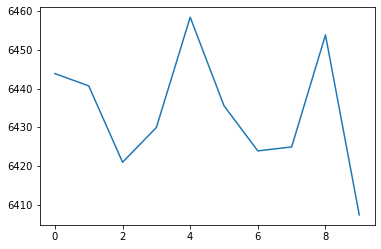

In [18]:
env = gym.make('CartPole-v0').unwrapped
# env = gym.make('CartPole-v1').unwrapped
agent = AgentNN(env)
agent.load("saved/Cartpole-v0.best-2000")
agent.eps = 0.0
agent.optimizer = optim.SGD(agent.qf.parameters(), lr=0.000001, weight_decay=0.000001)
agent.runMany(10, maxStep=6000)

In [19]:
agent.runTest()
env.close()

Test episode 1, return = 1238.0316276550293 in 1000 steps


### plot Q function

In [33]:
def getArange(r, n):
    d = (r[1]-r[0])/n
    x = np.arange(r[0], r[1]+0.01, d)
    return x


def getAllStateTensor(agent, x0, i1, r1, i2, r2):
    x1 = getArange(r1, 20)
    n1 = len(x1)
    x2 = getArange(r2, 20)
    n2 = len(x2)
    S = np.zeros((n1*n2, agent.dimState))
    k = 0
    for i in range(n1):
        for j in range(n2):
            S[k] = x0
            S[k][i1] = x1[i]
            S[k][i2] = x2[j]
            k += 1

    ST = torch.tensor(S, dtype=torch.float32)
    return ST, x1, x2


def plotQ(agent, i1, i2):
    x0 = np.zeros(agent.dimState)
    low = agent.env.observation_space.low
    high = agent.env.observation_space.high
    ii1 = i1 - i1%2
    r1 = (low[ii1], high[ii1])
    ii2 = i2 - i2%2
    r2 = (low[ii2], high[ii2])
    S, x1, x2 = getAllStateTensor(agent, x0, i1, r1, i2, r2)
    S = S.to(agent.device)
    with torch.no_grad():
        Q = agent.qf(S)
    Q = Q.cpu().numpy()
    Qdiff = Q[:,0] - Q[:,1]
    N = len(x1)
    M = len(x2)
    imQ0 = Q[:,0].reshape((N,M))
    imQ1 = Q[:,1].reshape((N,M))
    imQdiff = Qdiff.reshape((N,M))

    vmin = -100
    vmax = 100
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(imQ0, vmin=vmin, vmax=vmax)
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(imQ1, vmin=vmin, vmax=vmax)
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(imQdiff, vmin=vmin/10, vmax=vmax/10)

    plt.show()
    # plt.draw()
    # plt.pause(1)

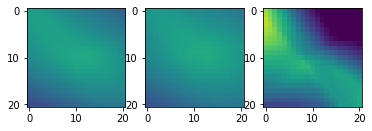

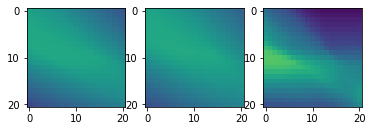

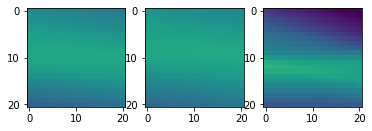

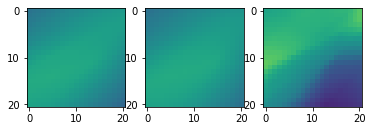

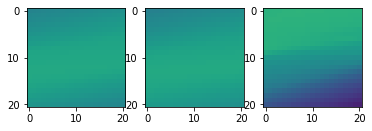

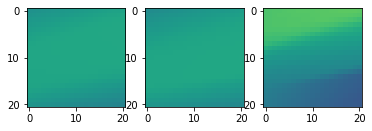

In [71]:
plotQ(agent, 0, 1)
plotQ(agent, 0, 2)
plotQ(agent, 0, 3)
plotQ(agent, 1, 2)
plotQ(agent, 1, 3)
plotQ(agent, 2, 3)

### test trained agent

In [37]:
env = gym.make('CartPole-v0').unwrapped
# env = gym.wrappers.Monitor(env, 'Cartpole-v0.result', force=True)
agent = AgentNN(env)
agent.load("saved/Cartpole-v0.best-200")
agent.runTest()
env.close()

1 return = 262


In [36]:
env.close()